![title](ANTI-INFECTIVES-RGB_200pc.png)

# Abstract
We are analysing normal versus oncogene-induced senescent cells to identify putative drug targets. We are particularly interested in transmembrane protein and protein with signal peptides that are likely to be transported on the cell plasma membrane.

### ** Index: **
1. [Load Dataset](#Load-Dataset)
2. [Normalization](#Normalization)
3. [R analysis](#R-analysis)
4. [Visualise P-values](#Visualise-P-values)
5. [Differential Expression Visualisation](#Differential-Expression-Visualisation)

In [1]:
%load_ext autoreload
%autoreload 2

In [80]:
%run external.py
import external

<Figure size 432x288 with 0 Axes>

In [3]:
# enables the %%R magic, not necessary if you've already done this
%load_ext rpy2.ipython
%matplotlib inline

plt.style.use('ggplot')
exp_palette = ["r"]*3+["g"]*3

In [4]:

TXT_PATH = os.path.join('D:', os.sep, 'michele', 'old_age', 'raw_4x', 'combined', 'txt')

# Load-Dataset
[Return to the top](#Abstract)

In [292]:
#load the datasetD:\michele\old_age\raw\combined\txt
df = pd.read_table(os.path.join(TXT_PATH, 'proteinGroups.txt'))
df.head()

#print(df.columns)
#df = df[df['Only identified by site']!='+']
#print(df.shape)
df = df[df['Potential contaminant']!='+']
print(df.shape)
df = df[df['Reverse']!='+']
print(df.shape)
df['unique_pep']=[int(n.split(';')[0]) for n in df['Peptide counts (unique)']]
#df = df[df['unique_pep']>=2]
print(df.shape)


#print(list(df.columns))
cols = ['Reporter intensity corrected {}'.format(n) for n in range(1,7)]
df['sum_int_corr'] = df[cols].sum(axis=1)
df = df[df['sum_int_corr']>0]

cols = ['Reporter intensity {}'.format(n) for n in range(1,7)]
df['sum_int'] = df[cols].sum(axis=1)
df = df[df['sum_int']>0]


print(df.shape)

data=df[cols]
data.columns = ['S1', 'S2', 'S3', 'C1', 'C2', 'C3']

(9776, 82)
(9240, 82)
(9240, 83)
(9109, 85)


In [293]:
#np.log10(df[['Intensity','sum_int','sum_int_corr']]).corr()#.plot(kind='scatter',x='Intensity',y='sum_int')

,Intensity,sum_int,sum_int_corr
Intensity,1.000000,0.936284,0.936284
sum_int,0.936284,1.000000,1.000000
sum_int_corr,0.936284,1.000000,1.000000


# Normalization
[Return to the top](#Abstract)

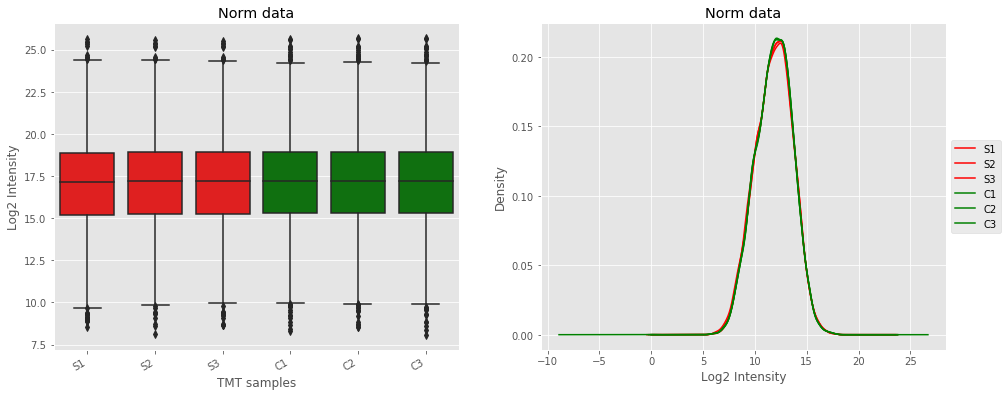

In [7]:
#we create normalization factors based on the average sum intensity of each channel
col_sum = data.sum(axis=0)
target = np.mean(col_sum)
norm_facs = target / col_sum
data_norm = data.multiply(norm_facs, axis=1)


fig,axes=plt.subplots(figsize=(16,6),ncols=2,nrows=1)
sns.boxplot(data=np.log2(data_norm), ax=axes[0],palette=exp_palette)
axes[0].set_xticklabels(data.columns, rotation=30, ha='right')
axes[0].set_title('Norm data')
axes[0].set_xlabel('TMT samples')
axes[0].set_ylabel('Log2 Intensity')
plt.ylabel('log2 of intensity')

np.log1p(data_norm).plot(kind='kde',ax=axes[1],color=exp_palette)
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title('Norm data')
axes[1].set_xlabel('Log2 Intensity')
plt.show()

[0.96589526 0.03215583]


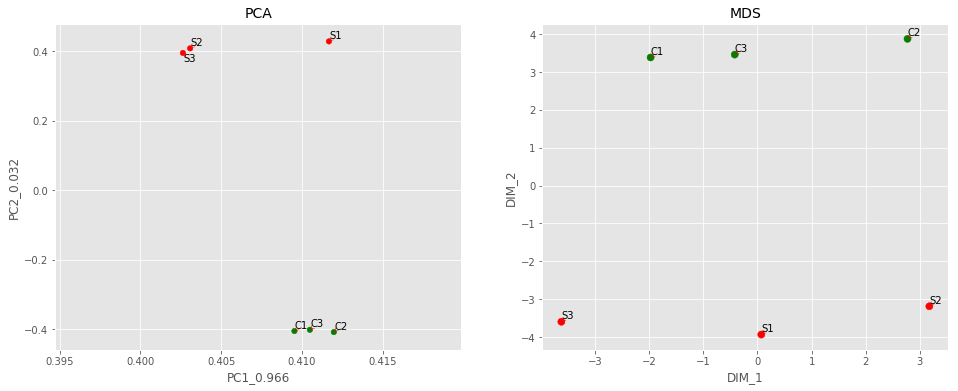

In [8]:
fig,axes=plt.subplots(figsize=(16,6), ncols=2,nrows=1)
external.make_pca(np.log2(data), exp_palette, ax=axes[0])
external.make_mds(np.log2(data), exp_palette, ax=axes[1])
plt.show()

In [9]:
df['Gene names']=['_'.join(n.split(';')[0].split(' ')[0].split('|')[1:]) for n in df['Fasta headers']]
data_norm['genes'] = data_norm.index.map(df['Gene names'])
data_norm['genes']=[str(n).split(';')[0] for n in data_norm['genes']]
data_norm['genes']=[str(n[0])+'_'+str(n[1]) for n in zip(data_norm.index.values,data_norm['genes'])]
data_norm.head()

,S1,S2,S3,C1,C2,C3,genes
92,4.551625e+05,6.091360e+05,6.313422e+05,560128.054973,575607.603398,570064.569455,92_ENST00000373020_O43657__TSPAN6
93,1.016116e+06,1.075470e+06,1.105336e+06,985247.548508,996391.926920,996688.494383,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1
94,5.619846e+04,6.360274e+04,6.522072e+04,55059.556868,54431.700368,53114.027243,94_ENST00000423670__X6RHX1_SCYL3
95,4.819037e+05,5.171650e+05,5.284362e+05,681856.225259,699113.121572,674029.723254,95_ENST00000002165_Q9BTY2__FUCA2
96,9.817711e+05,9.939697e+05,9.566238e+05,812067.048549,794768.557355,791223.525887,96_ENST00000650454_P48506_Q14TF0_GCLC


# R analysis
[Return to the top](#Abstract)

In [10]:
%%R -i data_norm
options(warn=-1)
library("tidyverse")
library("psych")
library("gridExtra")
library("scales")
library("limma") 
library("edgeR")

In [11]:
%%R
accession <- data_norm$'genes'
limma_data = within(data_norm, rm('genes'))

In [12]:
%R head(limma_data)

,S1,S2,S3,C1,C2,C3
92,4.551625e+05,6.091360e+05,6.313422e+05,560128.054973,575607.603398,570064.569455
93,1.016116e+06,1.075470e+06,1.105336e+06,985247.548508,996391.926920,996688.494383
94,5.619846e+04,6.360274e+04,6.522072e+04,55059.556868,54431.700368,53114.027243
95,4.819037e+05,5.171650e+05,5.284362e+05,681856.225259,699113.121572,674029.723254
96,9.817711e+05,9.939697e+05,9.566238e+05,812067.048549,794768.557355,791223.525887
97,2.342104e+04,3.417722e+04,4.125811e+04,39620.708466,39641.097443,37358.906914


In [13]:
%%R
row.names(limma_data) <- accession # add accessions as row names
# set up the design matrix
group <- as.factor(c(rep("senescent", 3), rep("control", 3)))
group <- factor(group, levels(group)[c(2, 1)]) # set the factor order
design <- model.matrix(~ 0 + group)
colnames(design) <- c("senescent", "control")

# make the contrast
contrast <- makeContrasts(senescent-control, levels = design)

S <- 1:3
C <- 4:6
# do the linear model fitting on log2 values
limma_log_data <- log2(limma_data[c(S, C)])
fit <- lmFit(limma_log_data, design)

# get the fit for the contrast of interest
fit2 <- contrasts.fit(fit, contrast)

# do the empirical Bayes moderation of the test statistic (with trended variance)
fit2 <- eBayes(fit2, trend = TRUE)

# grab the information in topTable so we can get the data to plot candidates
# the coef parameter has to do with the contrast of interest
# specify no sorting of results and a number that is longer than the data table
tt_limma <- topTable(fit2, coef = 1, sort.by = "none", number = Inf)


In [22]:
#check
#%R -o design
#print(design)
#%R design

In [20]:
# let's see how many up and down candidates, and the top tags
%R topTable(fit2)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
2955_ENST00000409512_Q16719__KYNU,1.535187,19.903208,73.406895,9.622616e-11,2.957397e-07,15.420605
2462_ENST00000456829_O00534_A0A024R3H3_VWA5A,1.330966,21.007355,71.530736,1.138616e-10,2.957397e-07,15.289052
6088_ENST00000290271_P52823__STC1,1.760951,18.541959,71.031983,1.191593e-10,2.957397e-07,15.253126
1357_ENST00000443427_P03372_G4XH65_ESR1,1.730415,20.783093,69.077759,1.428469e-10,2.957397e-07,15.108335
4752_ENST00000354960_O76074__PDE5A,-1.095420,21.255205,-65.386325,2.041130e-10,2.957397e-07,14.816205
9251_ENST00000585132_Q13772_A0A024QZI5_NCOA4,-1.988149,18.937436,-65.123722,2.095209e-10,2.957397e-07,14.794439
1746_ENST00000261596_Q92539__LPIN2,1.349120,18.678007,63.440691,2.483797e-10,2.957397e-07,14.651644
3024_ENST00000354777_Q5T9L3__WLS,1.103897,20.392048,63.005752,2.597340e-10,2.957397e-07,14.613793
6108_ENST00000409174__E9PB90_HK2,1.090448,20.262484,59.292103,3.854232e-10,3.569352e-07,14.273704
6212_ENST00000389805_Q13501__SQSTM1,-1.363349,19.718006,-58.300293,4.300597e-10,3.569352e-07,14.177460


In [23]:
#%%R
#limma_data$ave_med <- rowMeans(limma_data[S])
#limma_data$ave_exo  <- rowMeans(limma_data[C])
#limma_data$logFC <- log2(limma_data$ave_exo / limma_data$ave_med)
#limma_data$FC <- ifelse(limma_data$ave_exo > limma_data$ave_med, 
                          #(limma_data$ave_exo / limma_data$ave_med), 
                          #(-1 * limma_data$ave_med / limma_data$ave_exo))


In [24]:
%%R
# statisticl test results
limma_data$Acc <- accession
limma_data$PValue <- tt_limma$P.Value
limma_data$FDR <- tt_limma$adj.P.Val
head(limma_data)
# add a DE candidate status column
limma_data$candidate <- cut(limma_data$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                           labels = c("high", "med", "low", "no"))


In [25]:
%R head(limma_data)

,S1,S2,S3,C1,C2,C3,Acc,PValue,FDR,candidate
92_ENST00000373020_O43657__TSPAN6,4.551625e+05,6.091360e+05,6.313422e+05,560128.054973,575607.603398,570064.569455,92_ENST00000373020_O43657__TSPAN6,0.849547,0.877782,no
93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,1.016116e+06,1.075470e+06,1.105336e+06,985247.548508,996391.926920,996688.494383,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.018595,0.033227,med
94_ENST00000423670__X6RHX1_SCYL3,5.619846e+04,6.360274e+04,6.522072e+04,55059.556868,54431.700368,53114.027243,94_ENST00000423670__X6RHX1_SCYL3,0.025174,0.043055,med
95_ENST00000002165_Q9BTY2__FUCA2,4.819037e+05,5.171650e+05,5.284362e+05,681856.225259,699113.121572,674029.723254,95_ENST00000002165_Q9BTY2__FUCA2,0.000017,0.000112,high
96_ENST00000650454_P48506_Q14TF0_GCLC,9.817711e+05,9.939697e+05,9.566238e+05,812067.048549,794768.557355,791223.525887,96_ENST00000650454_P48506_Q14TF0_GCLC,0.000007,0.000064,high
97_ENST00000509541__A0A2R8Y648_GCLC,2.342104e+04,3.417722e+04,4.125811e+04,39620.708466,39641.097443,37358.906914,97_ENST00000509541__A0A2R8Y648_GCLC,0.199938,0.258808,no


In [26]:
# count candidates
print("Candidate Counts:")
%R summary(limma_data$candidate)

Candidate Counts:


array([4139, 1309,  627, 3034], dtype=int32)

In [27]:
%R -o limma_data

In [32]:
limma_data.head()

,S1,S2,S3,C1,C2,C3,Acc,PValue,FDR,candidate
92_ENST00000373020_O43657__TSPAN6,4.551625e+05,6.091360e+05,6.313422e+05,560128.054973,575607.603398,570064.569455,92_ENST00000373020_O43657__TSPAN6,0.849547,0.877782,no
93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,1.016116e+06,1.075470e+06,1.105336e+06,985247.548508,996391.926920,996688.494383,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.018595,0.033227,med
94_ENST00000423670__X6RHX1_SCYL3,5.619846e+04,6.360274e+04,6.522072e+04,55059.556868,54431.700368,53114.027243,94_ENST00000423670__X6RHX1_SCYL3,0.025174,0.043055,med
95_ENST00000002165_Q9BTY2__FUCA2,4.819037e+05,5.171650e+05,5.284362e+05,681856.225259,699113.121572,674029.723254,95_ENST00000002165_Q9BTY2__FUCA2,0.000017,0.000112,high
96_ENST00000650454_P48506_Q14TF0_GCLC,9.817711e+05,9.939697e+05,9.566238e+05,812067.048549,794768.557355,791223.525887,96_ENST00000650454_P48506_Q14TF0_GCLC,0.000007,0.000064,high


In [30]:
#clean R name space
%R rm(list=ls())

In [33]:
#data_def.head()

# Visualise P-values
[Return to the top](#Abstract)

In [34]:
to_drop = ['S1','S2','S3','C1','C2','C3']
limma_data.drop(to_drop,axis=1,inplace=True)
print(data_norm.shape)
data_def = limma_data.join(data_norm.set_index('genes'))
print(data_def.shape)
data_def.head()

(9109, 7)
(9109, 10)


,Acc,PValue,FDR,candidate,S1,S2,S3,C1,C2,C3
92_ENST00000373020_O43657__TSPAN6,92_ENST00000373020_O43657__TSPAN6,0.849547,0.877782,no,4.551625e+05,6.091360e+05,6.313422e+05,560128.054973,575607.603398,570064.569455
93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.018595,0.033227,med,1.016116e+06,1.075470e+06,1.105336e+06,985247.548508,996391.926920,996688.494383
94_ENST00000423670__X6RHX1_SCYL3,94_ENST00000423670__X6RHX1_SCYL3,0.025174,0.043055,med,5.619846e+04,6.360274e+04,6.522072e+04,55059.556868,54431.700368,53114.027243
95_ENST00000002165_Q9BTY2__FUCA2,95_ENST00000002165_Q9BTY2__FUCA2,0.000017,0.000112,high,4.819037e+05,5.171650e+05,5.284362e+05,681856.225259,699113.121572,674029.723254
96_ENST00000650454_P48506_Q14TF0_GCLC,96_ENST00000650454_P48506_Q14TF0_GCLC,0.000007,0.000064,high,9.817711e+05,9.939697e+05,9.566238e+05,812067.048549,794768.557355,791223.525887


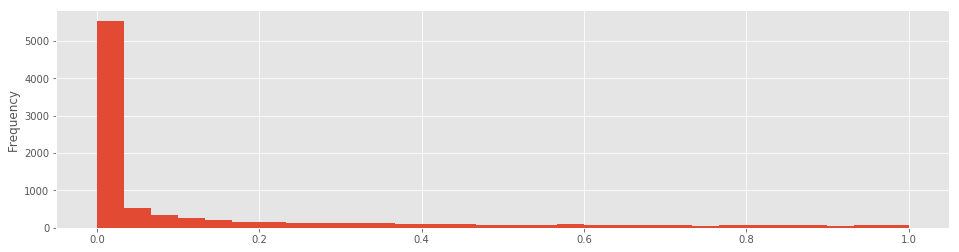

In [35]:
data_def.PValue.plot(kind='hist', bins=30,figsize=(16,4))
plt.show()

# Differential Expression Visualisation
[Return to the top](#Abstract)

In [36]:
#add some values for plotting results
data_def['mean_s'] = data_def[['S1','S2','S3']].mean(axis=1)
data_def['mean_c'] = data_def[['C1','C2','C3']].mean(axis=1)
data_def['Log2FC'] = np.log2(data_def['mean_c']/data_def['mean_s'])
data_def['Log10signal'] = np.log10(data_def['mean_c']+data_def['mean_s'])
data_def['-Log10PValue'] = -np.log10(data_def['PValue'])
data_def['Log10signal_Q'] = pd.qcut(data_def['Log10signal'], 50, range(50))

In [37]:
print(data_def.shape)
data_def['index']=[int(n.split('_')[0]) for n in data_def['Acc']]
data_def=data_def.set_index('index',drop=True)

(9109, 16)


In [38]:
data_def.head()

,Acc,PValue,FDR,candidate,S1,S2,S3,C1,C2,C3,mean_s,mean_c,Log2FC,Log10signal,-Log10PValue,Log10signal_Q
index,,,,,,,,,,,,,,,,
92,92_ENST00000373020_O43657__TSPAN6,0.849547,0.877782,no,4.551625e+05,6.091360e+05,6.313422e+05,560128.054973,575607.603398,570064.569455,5.652136e+05,568600.075942,0.008618,6.054542,0.070812,38
93,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.018595,0.033227,med,1.016116e+06,1.075470e+06,1.105336e+06,985247.548508,996391.926920,996688.494383,1.065641e+06,992775.989937,-0.102181,6.313533,1.730594,43
94,94_ENST00000423670__X6RHX1_SCYL3,0.025174,0.043055,med,5.619846e+04,6.360274e+04,6.522072e+04,55059.556868,54431.700368,53114.027243,6.167397e+04,54201.761493,-0.186322,5.063992,1.599045,15
95,95_ENST00000002165_Q9BTY2__FUCA2,0.000017,0.000112,high,4.819037e+05,5.171650e+05,5.284362e+05,681856.225259,699113.121572,674029.723254,5.091683e+05,684999.690028,0.427961,6.077065,4.780426,39
96,96_ENST00000650454_P48506_Q14TF0_GCLC,0.000007,0.000064,high,9.817711e+05,9.939697e+05,9.566238e+05,812067.048549,794768.557355,791223.525887,9.774549e+05,799353.043930,-0.290197,6.249640,5.134838,42


In [39]:
histones = [
'ENSG00000124575','HIST1H1D','H1D','H1',
'ENSG00000124610','HIST1H1A','H1A','H1',
'ENSG00000124635','HIST1H2BJ','H2BJ','Core',
'ENSG00000278705','HIST1H4B','H4B','Core',
'ENSG00000168298','HIST1H1E','H1E','H1',
'ENSG00000276368','HIST1H2AJ','H2AJ','Core',
'ENSG00000284841','HIST3H2A','H2A','Core',
'ENSG00000203852','HIST2H3A','H3A','Core',
'ENSG00000184270','HIST2H2AB','H2AB','Core',
'ENSG00000184357','HIST1H1B','H1B','H1',
'ENSG00000276410','HIST1H2BB','H2BB','Core',
'ENSG00000185130','HIST1H2BL','H2BL','Core',
'ENSG00000187837','HIST1H1C','H1C','H1',
'ENSG00000278828','HIST1H3H','H3H','Core',
'ENSG00000203814','HIST2H2BF','H2BF','Core',
'ENSG00000203818','HIST2H3PS2','H3PS2','Core',
'ENSG00000184897','H1FX','H1FX','H1',
'ENSG00000189060','H1F0','H1F0','H1',
'ENSG00000149948','HMGA2','HMGA2','H1']
len(histones)/4
histones_df = pd.DataFrame()
histones_df['genes']=[n for index,n in enumerate(histones) if index%4==0]
histones_df['names']=[n for index,n in enumerate(histones[1:]) if index%4==0]
histones_df['short_name']=[n for index,n in enumerate(histones[2:]) if index%4==0]
histones_df['class']=[n for index,n in enumerate(histones[3:]) if index%4==0]

In [40]:
data_def.head()

,Acc,PValue,FDR,candidate,S1,S2,S3,C1,C2,C3,mean_s,mean_c,Log2FC,Log10signal,-Log10PValue,Log10signal_Q
index,,,,,,,,,,,,,,,,
92,92_ENST00000373020_O43657__TSPAN6,0.849547,0.877782,no,4.551625e+05,6.091360e+05,6.313422e+05,560128.054973,575607.603398,570064.569455,5.652136e+05,568600.075942,0.008618,6.054542,0.070812,38
93,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.018595,0.033227,med,1.016116e+06,1.075470e+06,1.105336e+06,985247.548508,996391.926920,996688.494383,1.065641e+06,992775.989937,-0.102181,6.313533,1.730594,43
94,94_ENST00000423670__X6RHX1_SCYL3,0.025174,0.043055,med,5.619846e+04,6.360274e+04,6.522072e+04,55059.556868,54431.700368,53114.027243,6.167397e+04,54201.761493,-0.186322,5.063992,1.599045,15
95,95_ENST00000002165_Q9BTY2__FUCA2,0.000017,0.000112,high,4.819037e+05,5.171650e+05,5.284362e+05,681856.225259,699113.121572,674029.723254,5.091683e+05,684999.690028,0.427961,6.077065,4.780426,39
96,96_ENST00000650454_P48506_Q14TF0_GCLC,0.000007,0.000064,high,9.817711e+05,9.939697e+05,9.566238e+05,812067.048549,794768.557355,791223.525887,9.774549e+05,799353.043930,-0.290197,6.249640,5.134838,42


In [43]:
#add histone index
ids = []
for gene in histones_df['genes']:
    res =list(df[df['Fasta headers'].str.contains(gene)].index.values)
    ids+=res
histones_df['index_ref']=ids
histones_df.head()

,genes,names,short_name,class,index_ref
0,ENSG00000124575,HIST1H1D,H1D,H1,3533
1,ENSG00000124610,HIST1H1A,H1A,H1,3538
2,ENSG00000124635,HIST1H2BJ,H2BJ,Core,3541
3,ENSG00000278705,HIST1H4B,H4B,Core,6046
4,ENSG00000168298,HIST1H1E,H1E,H1,7016


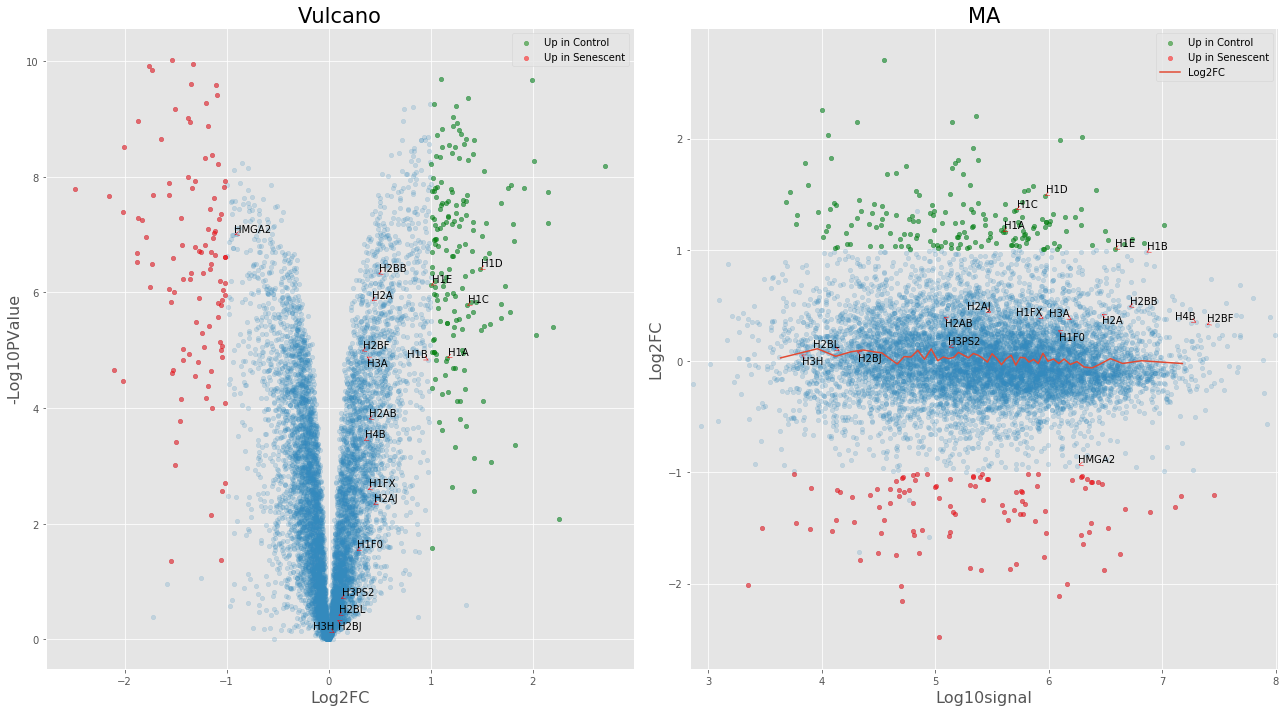

In [326]:
fig,axes=plt.subplots(figsize=(18,10), ncols=2, nrows=1)

make_vulcano(data_def, axes[0], x='Log2FC',y='-Log10PValue', 
             annot_index=histones_df['index_ref'],
             annot_names = histones_df['short_name'],
             title='Vulcano')

make_vulcano(data_def, axes[1], x='Log10signal', y='Log2FC', 
             annot_index=histones_df['index_ref'],
             annot_names = histones_df['short_name'],
             title='MA')

data_def.groupby('Log10signal_Q')[['Log10signal','Log2FC']].mean().plot(ax=axes[1],
                                                                        x='Log10signal',
                                                                        y='Log2FC')

axes[1].set_xlim(data_def['Log10signal'].min()-data_def['Log10signal'].min()*0.01,
                 data_def['Log10signal'].max()+data_def['Log10signal'].min()*0.01)

axes[0].title.set_size(21)
axes[1].title.set_size(21)
axes[0].yaxis.label.set_size(16)
axes[0].xaxis.label.set_size(16)
axes[1].yaxis.label.set_size(16)
axes[1].xaxis.label.set_size(16)
plt.tight_layout()
plt.savefig('Histone_analysis.png')
plt.show()

In [161]:
cdks = [
'ENSG00000058091','CDK14',
'ENSG00000059758','CDK17',
'ENSG00000065883','CDK13',
'ENSG00000101391','CDK5RAP1',
'ENSG00000102225','CDK16',
'ENSG00000105810','CDK6',
'ENSG00000108465','CDK5RAP3',
'ENSG00000111276','CDKN1B',
'ENSG00000111328','CDK2AP1',
'ENSG00000123374','CDK2',
'ENSG00000124762','CDKN1A',
'ENSG00000273707','CDKN1C',
'ENSG00000132964','CDK8',
'ENSG00000134058','CDK7',
'ENSG00000135446','CDK4',
'ENSG00000136807','CDK9',
'ENSG00000136861','CDK5RAP2',
'ENSG00000145996','CDKAL1',
'ENSG00000147889','CDKN2A',
'ENSG00000155111','CDK19',
'ENSG00000163482','STK36',
'ENSG00000164885','CDK5',
'ENSG00000167258','CDK12',
'ENSG00000168564','CDKN2AIP',
'ENSG00000185324','CDK10',
'ENSG00000248333','CDK11B']
cdks_df = pd.DataFrame()
cdks_df['genes']=[n for index,n in enumerate(cdks) if index%2==0]
cdks_df['names']=[n for index,n in enumerate(cdks[1:]) if index%2==0]
#add  index
ids = []
for gene in cdks_df['genes']:
    res =list(df[df['Fasta headers'].str.contains(gene)].index.values)
    if len(res)>1:
        res = [res[0]]
    ids+=res
cdks_df['index_ref']=ids
cdks_df.head()

,genes,names,index_ref
0,ENSG00000058091,CDK14,574
1,ENSG00000059758,CDK17,591
2,ENSG00000065883,CDK13,695
3,ENSG00000101391,CDK5RAP1,1726
4,ENSG00000102225,CDK16,1798


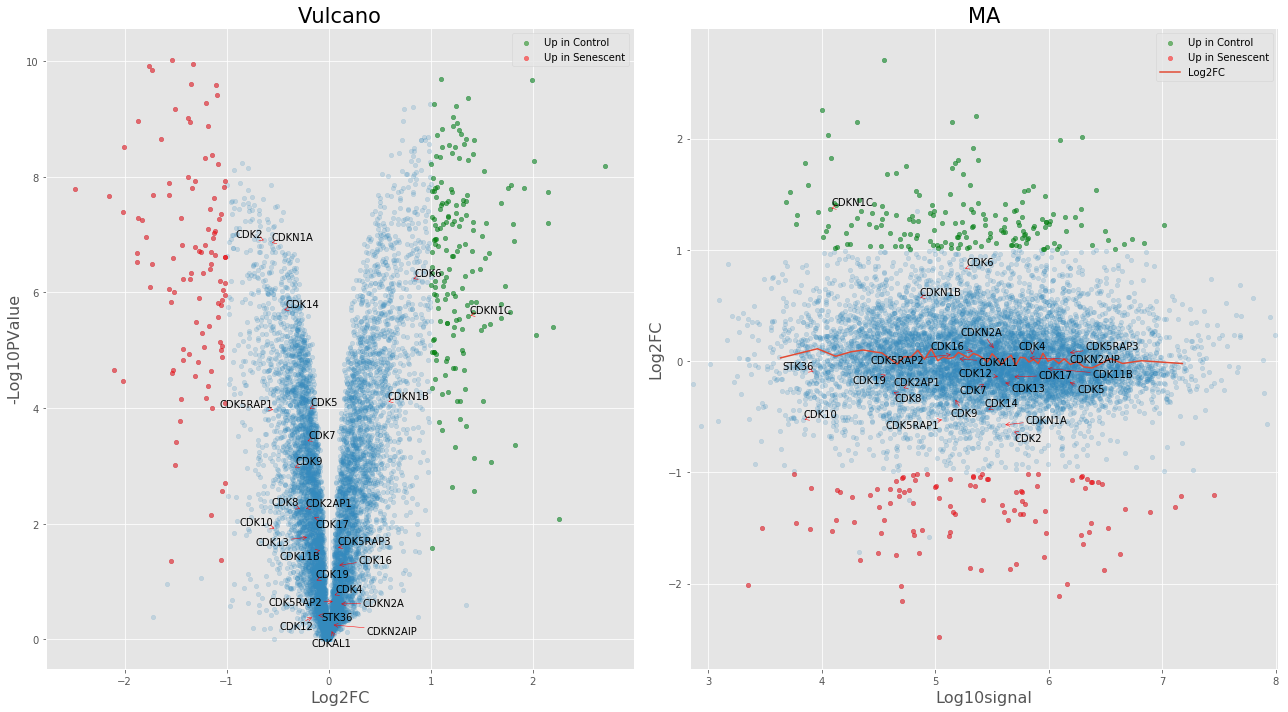

In [327]:
fig,axes=plt.subplots(figsize=(18,10), ncols=2, nrows=1)

make_vulcano(data_def, axes[0], x='Log2FC',y='-Log10PValue', 
             annot_index=cdks_df['index_ref'],
             annot_names = cdks_df['names'],
             title='Vulcano')

make_vulcano(data_def, axes[1], x='Log10signal', y='Log2FC', 
             annot_index=cdks_df['index_ref'],
             annot_names = cdks_df['names'],
             title='MA')

data_def.groupby('Log10signal_Q')[['Log10signal','Log2FC']].mean().plot(ax=axes[1],
                                                                        x='Log10signal',
                                                                        y='Log2FC')

axes[1].set_xlim(data_def['Log10signal'].min()-data_def['Log10signal'].min()*0.01,
                 data_def['Log10signal'].max()+data_def['Log10signal'].min()*0.01)

axes[0].title.set_size(21)
axes[1].title.set_size(21)
axes[0].yaxis.label.set_size(16)
axes[0].xaxis.label.set_size(16)
axes[1].yaxis.label.set_size(16)
axes[1].xaxis.label.set_size(16)
plt.tight_layout()
plt.savefig('CDK_analysis.png')
plt.show()

In [155]:
#PMID: 25412306
#Characterization of novel markers of senescence 
#and their prognostic potential in cancer
#EJp21 and EJp16
markers = [
'ENSG00000149177','DEP1','PTPRJ','UP',
#'ENSG00000086730','NTAL','LAT2','UP',
'ENSG00000109062','EBP50','SLC9A3R1','UP',
'ENSG00000103496','STX4','STX4','UP',
'ENSG00000049245','VAMP3','VAMP3','UP',
'ENSG00000102401','ARMX3','ARMCX3','UP',
'ENSG00000273686','B2MG','B2M','UP',
'ENSG00000115365','LANCL1','LANCL1','UP',
'ENSG00000122958','VPS26A','VPS26A','UP',
'ENSG00000105223','PLD3','PLD3','UP'
]
markers_df = pd.DataFrame()
markers_df['genes']=[n for index,n in enumerate(markers) if index%4==0]
markers_df['names']=[n for index,n in enumerate(markers[1:]) if index%4==0]
markers_df['short_name']=[n for index,n in enumerate(markers[2:]) if index%4==0]
markers_df['class']=[n for index,n in enumerate(markers[3:]) if index%4==0]
#add  index
ids = []
for gene in markers_df['genes']:
    res =list(df[df['Fasta headers'].str.contains(gene)].index.values)
    print(res)
    ids+=res
markers_df['index_ref']=ids
markers_df.head()

[5534]
[2394]
[1902]
[486]
[1811]
[6826]
[2896]
[3414]
[2049]


,genes,names,short_name,class,index_ref
0,ENSG00000149177,DEP1,PTPRJ,UP,5534
1,ENSG00000109062,EBP50,SLC9A3R1,UP,2394
2,ENSG00000103496,STX4,STX4,UP,1902
3,ENSG00000049245,VAMP3,VAMP3,UP,486
4,ENSG00000102401,ARMX3,ARMCX3,UP,1811


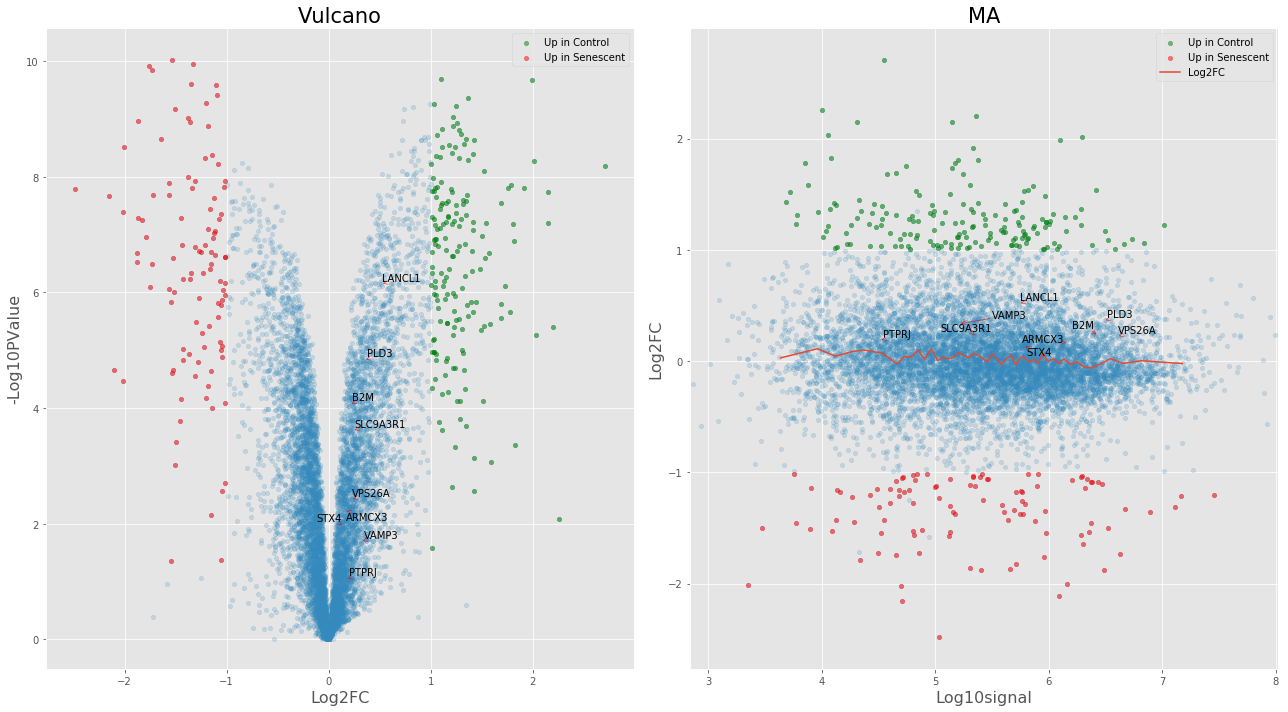

In [328]:
fig,axes=plt.subplots(figsize=(18,10), ncols=2, nrows=1)

make_vulcano(data_def, axes[0], x='Log2FC',y='-Log10PValue', 
             annot_index=markers_df['index_ref'],
             annot_names = markers_df['short_name'],
             title='Vulcano')

make_vulcano(data_def, axes[1], x='Log10signal', y='Log2FC', 
             annot_index=markers_df['index_ref'],
             annot_names = markers_df['short_name'],
             title='MA')

data_def.groupby('Log10signal_Q')[['Log10signal','Log2FC']].mean().plot(ax=axes[1],
                                                                        x='Log10signal',
                                                                        y='Log2FC')

axes[1].set_xlim(data_def['Log10signal'].min()-data_def['Log10signal'].min()*0.01,
                 data_def['Log10signal'].max()+data_def['Log10signal'].min()*0.01)

axes[0].title.set_size(21)
axes[1].title.set_size(21)
axes[0].yaxis.label.set_size(16)
axes[0].xaxis.label.set_size(16)
axes[1].yaxis.label.set_size(16)
axes[1].xaxis.label.set_size(16)
plt.tight_layout()
plt.savefig('Marker_analysis.png')
plt.show()

# Copy Number
[Return to the top](#Abstract)

## Histons selection

In [53]:
data_def.head()

,Acc,PValue,FDR,candidate,S1,S2,S3,C1,C2,C3,mean_s,mean_c,Log2FC,Log10signal,-Log10PValue,Log10signal_Q
index,,,,,,,,,,,,,,,,
92,92_ENST00000373020_O43657__TSPAN6,0.849547,0.877782,no,4.551625e+05,6.091360e+05,6.313422e+05,560128.054973,575607.603398,570064.569455,5.652136e+05,568600.075942,0.008618,6.054542,0.070812,38
93,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.018595,0.033227,med,1.016116e+06,1.075470e+06,1.105336e+06,985247.548508,996391.926920,996688.494383,1.065641e+06,992775.989937,-0.102181,6.313533,1.730594,43
94,94_ENST00000423670__X6RHX1_SCYL3,0.025174,0.043055,med,5.619846e+04,6.360274e+04,6.522072e+04,55059.556868,54431.700368,53114.027243,6.167397e+04,54201.761493,-0.186322,5.063992,1.599045,15
95,95_ENST00000002165_Q9BTY2__FUCA2,0.000017,0.000112,high,4.819037e+05,5.171650e+05,5.284362e+05,681856.225259,699113.121572,674029.723254,5.091683e+05,684999.690028,0.427961,6.077065,4.780426,39
96,96_ENST00000650454_P48506_Q14TF0_GCLC,0.000007,0.000064,high,9.817711e+05,9.939697e+05,9.566238e+05,812067.048549,794768.557355,791223.525887,9.774549e+05,799353.043930,-0.290197,6.249640,5.134838,42


In [93]:
from scipy.constants import Avogadro
from typing import List
def add_copy_number(df:pd.DataFrame, 
                    intensity_field:str, 
                    target_columns:List[str],
                    histons:List[int], 
                    mw_field:str,
                    )->'Protein Copy Number df':
    '''
    Implement the proteomic ruler defined in Wiśniewski JR et al, 2014. PMID: 25225357.
    The normalized TMT intenisty are used to compute the contribution of each channel
    to the Intensity column of MaxQuant. 
    
    Assume 6.5 pg as the DNA mass of diploid human cells (Wiśniewski JR et al.)
    
    df: DataFrame with TMT intensity and Intensity columns
    intensity_field: name of MaxQuant Intensity column in df
    target_columns: names of TMT intensity columns
    histons: List of Histone proteins indexes in df
    mw_field: name of protein MW field in Kdalton (from MaxQuant)
    '''
    
    #sum of TMT channels
    target_sum = df[target_columns].sum(axis=1)
    #contribution of each TMT channel to the total signal
    target_frac = df[target_columns].div(target_sum, axis=0)
    del target_sum
    gc.collect()
    #conversion of TMT intensity to MaxQuant Intensity
    target_intensity = target_frac.multiply(df[intensity_field], axis=0)
    print('histons intensity percentage')
    print(target_intensity.loc[histons].sum()/target_intensity.sum()*100)
    #print(target_intensity.loc[histons].describe())
    
    #multiply by avogardo constant and weigth of human DNA in diploid cell
    temp = target_intensity*Avogadro*6.5e-12 #DNA in grams
    #Divide by MW in dalton
    temp = temp.div(df[mw_field]*1000, axis=0)
    #Divide by histone intensity
    temp = temp.div(target_intensity.loc[histons].sum(),axis=1)
    temp.columns = [n+'_copy_number' for n in temp.columns]
    print(temp.describe())
    return temp


In [74]:
print(data_def.shape, df.shape)
data_def = data_def.join(df[['Intensity', 'Mol. weight [kDa]']])
print(data_def.shape)
data_def.head()

(9109, 18) (9109, 85)
(9109, 18)


,Acc,PValue,FDR,candidate,S1,S2,S3,C1,C2,C3,mean_s,mean_c,Log2FC,Log10signal,-Log10PValue,Log10signal_Q,Intensity,Mol. weight [kDa]
index,,,,,,,,,,,,,,,,,,
92,92_ENST00000373020_O43657__TSPAN6,0.849547,0.877782,no,4.551625e+05,6.091360e+05,6.313422e+05,560128.054973,575607.603398,570064.569455,5.652136e+05,568600.075942,0.008618,6.054542,0.070812,38,1829000000,27.563
93,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.018595,0.033227,med,1.016116e+06,1.075470e+06,1.105336e+06,985247.548508,996391.926920,996688.494383,1.065641e+06,992775.989937,-0.102181,6.313533,1.730594,43,5921300000,29.634
94,94_ENST00000423670__X6RHX1_SCYL3,0.025174,0.043055,med,5.619846e+04,6.360274e+04,6.522072e+04,55059.556868,54431.700368,53114.027243,6.167397e+04,54201.761493,-0.186322,5.063992,1.599045,15,105140000,65.298
95,95_ENST00000002165_Q9BTY2__FUCA2,0.000017,0.000112,high,4.819037e+05,5.171650e+05,5.284362e+05,681856.225259,699113.121572,674029.723254,5.091683e+05,684999.690028,0.427961,6.077065,4.780426,39,1574300000,54.066
96,96_ENST00000650454_P48506_Q14TF0_GCLC,0.000007,0.000064,high,9.817711e+05,9.939697e+05,9.566238e+05,812067.048549,794768.557355,791223.525887,9.774549e+05,799353.043930,-0.290197,6.249640,5.134838,42,3375600000,72.765


histons intensity percentage
S1    1.478188
S2    1.577690
S3    1.619001
C1    2.004954
C2    2.004583
C3    1.980843
dtype: float64
       S1_copy_number  S2_copy_number  S3_copy_number  C1_copy_number  \
count    9.109000e+03    9.109000e+03    9.109000e+03    9.109000e+03   
mean     7.092680e+05    6.650041e+05    6.480533e+05    5.255391e+05   
std      4.588563e+06    4.188722e+06    4.095479e+06    3.525378e+06   
min      4.019781e+01    4.008599e+01    3.962991e+01    3.261444e+01   
25%      6.268871e+03    6.411050e+03    6.378189e+03    5.267379e+03   
50%      3.350675e+04    3.317860e+04    3.259391e+04    2.636040e+04   
75%      1.916672e+05    1.870995e+05    1.820926e+05    1.455430e+05   
max      1.863036e+08    1.607228e+08    1.590564e+08    1.301052e+08   

       C2_copy_number  C3_copy_number  
count    9.109000e+03    9.109000e+03  
mean     5.252746e+05    5.324629e+05  
std      3.564744e+06    3.584582e+06  
min      3.314068e+01    0.000000e+00  
25%     

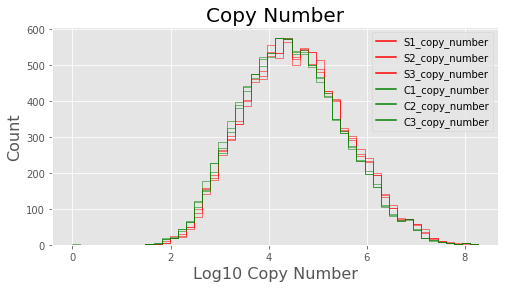

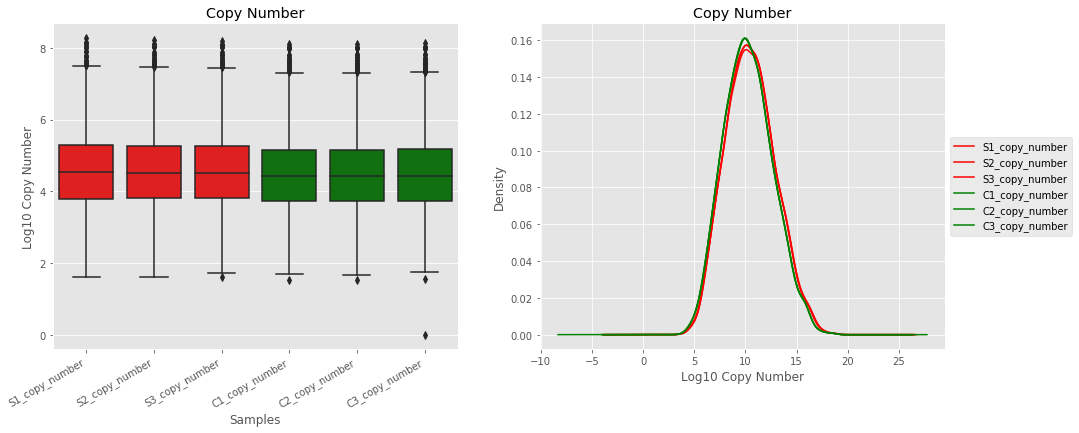

In [194]:
intensity_field = ['Intensity']
mw_field = 'Mol. weight [kDa]'
histons_core = list(histones_df[histones_df['class']=='Core']['index_ref'])
target_columns = ['S1','S2','S3','C1','C2','C3']

cn = add_copy_number(df=data_def, intensity_field='Intensity',
                target_columns = target_columns,
                histons=histons_core, mw_field=mw_field)

fig,ax=plt.subplots(figsize=(8,4))
np.log10(cn+1).plot(kind='hist', histtype='step',ax=ax, bins=50,color=['r','r','r','g','g','g'])
ax.set_xlabel('Log10 Copy Number',fontsize=16)
ax.set_ylabel('Count', fontsize=16)
hist_legend(ax)
plt.title('Copy Number', fontsize=20)
plt.show()
#cn['genes']=data_def['Acc']
#cn.head()

fig,axes=plt.subplots(figsize=(16,6),ncols=2,nrows=1)
sns.boxplot(data=np.log10(cn+1), ax=axes[0],palette=exp_palette)
axes[0].set_xticklabels(data.columns, rotation=30, ha='right')
axes[0].set_title('Copy Number')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Log10 Copy Number')


np.log1p(cn+1).plot(kind='kde',ax=axes[1],color=exp_palette)
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title('Copy Number')
axes[1].set_xlabel('Log10 Copy Number')
plt.show()

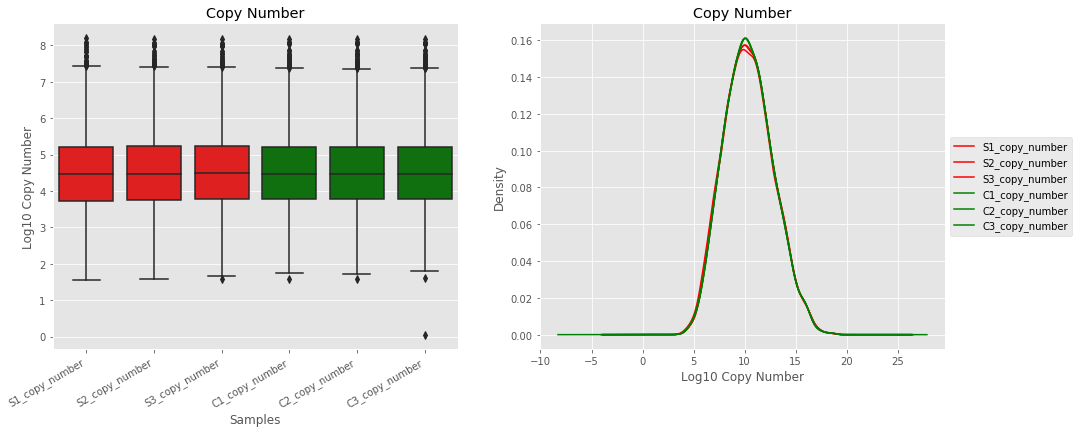

In [195]:
#we create normalization factors based on the average sum intensity of each channel
cn=cn+1
col_sum = cn.sum(axis=0)
target = np.mean(col_sum)
norm_facs = target / col_sum
cn_norm = cn.multiply(norm_facs, axis=1)

fig,axes=plt.subplots(figsize=(16,6),ncols=2,nrows=1)
sns.boxplot(data=np.log10(cn_norm), ax=axes[0],palette=exp_palette)
axes[0].set_xticklabels(data.columns, rotation=30, ha='right')
axes[0].set_title('Copy Number')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Log10 Copy Number')


np.log1p(cn_norm).plot(kind='kde',ax=axes[1],color=exp_palette)
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title('Copy Number')
axes[1].set_xlabel('Log10 Copy Number')
plt.show()

In [197]:
#data_def.head()

In [198]:
cn_norm['genes']=data_def['Acc'].values

In [199]:
%%R -i cn_norm
accession <- cn_norm$'genes'
limma_data = within(cn_norm, rm('genes'))

In [200]:
%R head(limma_data)

,S1_copy_number,S2_copy_number,S3_copy_number,C1_copy_number,C2_copy_number,C3_copy_number
92,221143.753343,300678.068317,311733.435440,274224.167548,280665.401434,278028.268054
93,818838.623941,880507.182941,905232.055568,800037.830436,805822.432072,806252.629530
94,6483.622993,7454.949487,7646.902607,6401.134428,6302.623815,6151.515437
95,97549.015323,106358.277003,108709.080355,139080.182025,142024.679562,136961.356424
96,212794.755983,218878.731137,210718.558096,177359.192048,172880.719347,172150.228670
97,1523.793556,2258.752177,2727.382897,2597.179138,2588.034771,2439.664370


In [201]:
%%R
row.names(limma_data) <- accession # add accessions as row names
# set up the design matrix
group <- as.factor(c(rep("senescent", 3), rep("control", 3)))
group <- factor(group, levels(group)[c(2, 1)]) # set the factor order
design <- model.matrix(~ 0 + group)
colnames(design) <- c("senescent", "control")

# make the contrast
contrast <- makeContrasts(senescent-control, levels = design)

S <- 1:3
C <- 4:6
# do the linear model fitting on log2 values
limma_log_data <- log2(limma_data[c(S, C)])
fit <- lmFit(limma_log_data, design)

# get the fit for the contrast of interest
fit2 <- contrasts.fit(fit, contrast)

# do the empirical Bayes moderation of the test statistic (with trended variance)
fit2 <- eBayes(fit2, trend = TRUE)

# grab the information in topTable so we can get the data to plot candidates
# the coef parameter has to do with the contrast of interest
# specify no sorting of results and a number that is longer than the data table
tt_limma <- topTable(fit2, coef = 1, sort.by = "none", number = Inf)


In [202]:
%R topTable(fit2)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
6088_ENST00000290271_P52823__STC1,1.769102,17.830113,71.638397,2.862755e-10,0.000001,14.321859
2462_ENST00000456829_O00534_A0A024R3H3_VWA5A,1.339124,19.218688,70.310531,3.213733e-10,0.000001,14.234956
3024_ENST00000354777_Q5T9L3__WLS,1.112056,20.003892,65.144343,5.150592e-10,0.000001,13.868859
1357_ENST00000443427_P03372_G4XH65_ESR1,1.738575,21.722868,63.892735,5.806626e-10,0.000001,13.772898
2955_ENST00000409512_Q16719__KYNU,1.543345,19.644413,63.152454,6.240227e-10,0.000001,13.714702
2119_ENST00000593562_Q16478__GRIK5,1.872634,15.350346,60.839787,7.858125e-10,0.000001,13.525675
261_ENST00000552962_P07585_Q6FH10_DCN,-1.241665,17.634512,-58.485622,1.002789e-09,0.000001,13.321323
6952_ENST00000593998_Q9BY76__ANGPTL4,1.384337,17.513041,58.229761,1.030322e-09,0.000001,13.298346
7561_ENST00000631404_P01112_X5D945_HRAS,1.365090,22.910890,55.434094,1.396287e-09,0.000001,13.036869
397_ENST00000037243_P60520__GABARAPL2,-1.285091,20.627320,-55.327922,1.412921e-09,0.000001,13.026549


In [203]:
%%R
# statisticl test results
limma_data$Acc <- accession
limma_data$PValue <- tt_limma$P.Value
limma_data$FDR <- tt_limma$adj.P.Val
head(limma_data)
# add a DE candidate status column
limma_data$candidate <- cut(limma_data$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                           labels = c("high", "med", "low", "no"))


In [204]:
%R head(limma_data)

,S1_copy_number,S2_copy_number,S3_copy_number,C1_copy_number,C2_copy_number,C3_copy_number,Acc,PValue,FDR,candidate
92_ENST00000373020_O43657__TSPAN6,221143.753343,300678.068317,311733.435440,274224.167548,280665.401434,278028.268054,92_ENST00000373020_O43657__TSPAN6,0.908501,0.928063,no
93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,818838.623941,880507.182941,905232.055568,800037.830436,805822.432072,806252.629530,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.028746,0.049573,med
94_ENST00000423670__X6RHX1_SCYL3,6483.622993,7454.949487,7646.902607,6401.134428,6302.623815,6151.515437,94_ENST00000423670__X6RHX1_SCYL3,0.032418,0.054901,low
95_ENST00000002165_Q9BTY2__FUCA2,97549.015323,106358.277003,108709.080355,139080.182025,142024.679562,136961.356424,95_ENST00000002165_Q9BTY2__FUCA2,0.000069,0.000382,high
96_ENST00000650454_P48506_Q14TF0_GCLC,212794.755983,218878.731137,210718.558096,177359.192048,172880.719347,172150.228670,96_ENST00000650454_P48506_Q14TF0_GCLC,0.000018,0.000147,high
97_ENST00000509541__A0A2R8Y648_GCLC,1523.793556,2258.752177,2727.382897,2597.179138,2588.034771,2439.664370,97_ENST00000509541__A0A2R8Y648_GCLC,0.236555,0.302213,no


In [205]:
%R -o limma_data

In [208]:
cn = pd.DataFrame(limma_data)
cn['index']=[int(n.split('_')[0]) for n in cn['Acc']]
cn.set_index('index',inplace=True,drop=True)

In [209]:
cn.head()

,S1_copy_number,S2_copy_number,S3_copy_number,C1_copy_number,C2_copy_number,C3_copy_number,Acc,PValue,FDR,candidate
index,,,,,,,,,,
92,221143.753343,300678.068317,311733.435440,274224.167548,280665.401434,278028.268054,92_ENST00000373020_O43657__TSPAN6,0.908501,0.928063,no
93,818838.623941,880507.182941,905232.055568,800037.830436,805822.432072,806252.629530,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.028746,0.049573,med
94,6483.622993,7454.949487,7646.902607,6401.134428,6302.623815,6151.515437,94_ENST00000423670__X6RHX1_SCYL3,0.032418,0.054901,low
95,97549.015323,106358.277003,108709.080355,139080.182025,142024.679562,136961.356424,95_ENST00000002165_Q9BTY2__FUCA2,0.000069,0.000382,high
96,212794.755983,218878.731137,210718.558096,177359.192048,172880.719347,172150.228670,96_ENST00000650454_P48506_Q14TF0_GCLC,0.000018,0.000147,high


In [210]:
for n in ['S1_copy_number','S2_copy_number','S3_copy_number',
          'C1_copy_number','C2_copy_number','C3_copy_number']:
    cn[n]=cn[n].astype(int)

In [213]:
#add some values for plotting results
cn['mean_s'] = cn[[n+'_copy_number' for n in ['S1','S2','S3']]].mean(axis=1)
cn['mean_c'] = cn[[n+'_copy_number' for n in ['C1','C2','C3']]].mean(axis=1)
cn['Log2FC'] = np.log2(cn['mean_c']/cn['mean_s'])
cn['Log10signal'] = np.log10(cn['mean_c']+cn['mean_s'])
cn['-Log10PValue'] = -np.log10(cn['PValue'])
cn['Log10signal_Q'] = pd.qcut(cn['Log10signal'], 50, range(50))

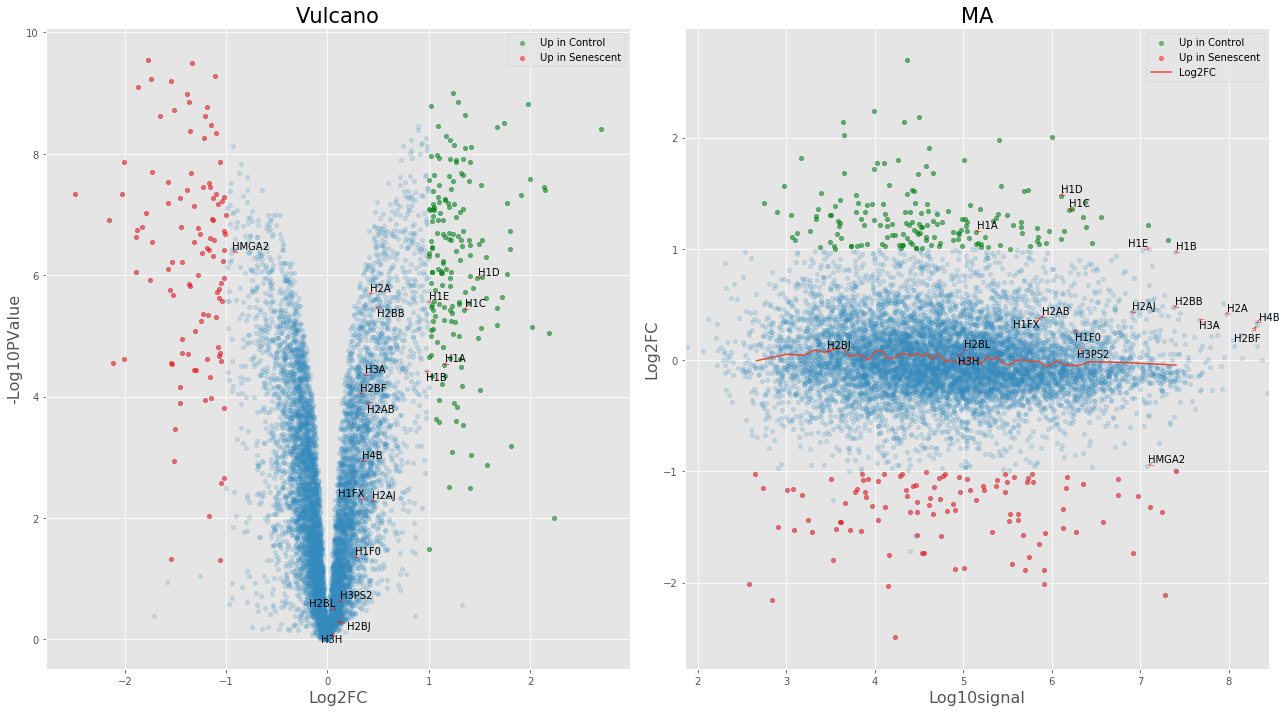

In [214]:
fig,axes=plt.subplots(figsize=(18,10), ncols=2, nrows=1)

make_vulcano(cn, axes[0], x='Log2FC',y='-Log10PValue', 
             annot_index=histones_df['index_ref'],
             annot_names = histones_df['short_name'],
             title='Vulcano')

make_vulcano(cn, axes[1], x='Log10signal', y='Log2FC', 
             annot_index=histones_df['index_ref'],
             annot_names = histones_df['short_name'],
             title='MA')

cn.groupby('Log10signal_Q')[['Log10signal','Log2FC']].mean().plot(ax=axes[1],
                                                                        x='Log10signal',
                                                                        y='Log2FC')

axes[1].set_xlim(cn['Log10signal'].min()-cn['Log10signal'].min()*0.01,
                 cn['Log10signal'].max()+cn['Log10signal'].min()*0.01)

axes[0].title.set_size(21)
axes[1].title.set_size(21)
axes[0].yaxis.label.set_size(16)
axes[0].xaxis.label.set_size(16)
axes[1].yaxis.label.set_size(16)
axes[1].xaxis.label.set_size(16)
plt.tight_layout()
plt.savefig('Histone_analysis.png')
plt.show()

In [216]:
cn.head()

,S1_copy_number,S2_copy_number,S3_copy_number,C1_copy_number,C2_copy_number,C3_copy_number,Acc,PValue,FDR,candidate,mean_s,mean_c,Log2FC,Log10signal,-Log10PValue,Log10signal_Q
index,,,,,,,,,,,,,,,,
92,221143,300678,311733,274224,280665,278028,92_ENST00000373020_O43657__TSPAN6,0.908501,0.928063,no,277851.333333,277639.000000,-0.001103,5.744677,0.041674,40
93,818838,880507,905232,800037,805822,806252,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.028746,0.049573,med,868192.333333,804037.000000,-0.110753,6.223296,1.541425,44
94,6483,7454,7646,6401,6302,6151,94_ENST00000423670__X6RHX1_SCYL3,0.032418,0.054901,low,7194.333333,6284.666667,-0.195025,4.129658,1.489214,13
95,97549,106358,108709,139080,142024,136961,95_ENST00000002165_Q9BTY2__FUCA2,0.000069,0.000382,high,104205.333333,139355.000000,0.419336,5.386607,4.159126,35
96,212794,218878,210718,177359,172880,172150,96_ENST00000650454_P48506_Q14TF0_GCLC,0.000018,0.000147,high,214130.000000,174129.666667,-0.298325,5.589122,4.745296,38


In [224]:
#data_def['Acc']

In [223]:
data_def['gene_id'] = [n.split('_')[1] for  n in data_def['Acc']]
cn['gene_id'] = [n.split('_')[1] for  n in data_def['Acc']]

In [270]:
rna = pd.read_csv('IMR90iRasPos_Vs_IMR90RasNeg.csv')
rna['gene_id']=rna['Row.names']
rna.set_index('gene_id', inplace=True,drop=True)
rna['rna_Log2FC']=rna['log2FoldChange']*-1
rna.head()

,Row.names,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Associated.Gene.Name,rna_Log2FC
gene_id,,,,,,,,,
ENSG00000072041,ENSG00000072041,3694.228605,3.859109,0.055265,69.829322,0.0,0.0,SLC6A15,-3.859109
ENSG00000085117,ENSG00000085117,3598.241821,2.768068,0.063402,43.659300,0.0,0.0,CD82,-2.768068
ENSG00000108932,ENSG00000108932,2148.510407,6.717515,0.164190,40.912945,0.0,0.0,SLC16A6,-6.717515
ENSG00000115919,ENSG00000115919,330.176513,5.006367,0.120859,41.423075,0.0,0.0,KYNU,-5.006367
ENSG00000116729,ENSG00000116729,17036.347468,2.854130,0.033170,86.044323,0.0,0.0,WLS,-2.854130


In [244]:
res = {}
for n in open('mart_export_Human_genes_GRCh38.p1206062019.fasta'):
    if n.startswith('>'):
        #print (n)
        res[n.split('|')[1]]=n.split('|')[0][1:]


In [271]:
temp_cn = cn[['gene_id','Log2FC']]
temp_cn['gene_id']=[res[n] for n in temp_cn['gene_id']]
temp_cn = temp_cn.groupby('gene_id').mean()
temp_cn.columns = ['cn_Log2FC']
temp_cn.head()

,cn_Log2FC
gene_id,
ENSG00000000003,-0.001103
ENSG00000000419,-0.110753
ENSG00000000457,-0.195025
ENSG00000001036,0.419336
ENSG00000001084,-0.034996


In [272]:
temp_tmt = data_def[['gene_id','Log2FC']]
temp_tmt['gene_id']=[res[n] for n in temp_tmt['gene_id']]
temp_tmt = temp_tmt.groupby('gene_id').mean()
temp_tmt.columns = ['tmt_Log2FC']
temp_tmt.head()

,tmt_Log2FC
gene_id,
ENSG00000000003,0.008618
ENSG00000000419,-0.102181
ENSG00000000457,-0.186322
ENSG00000001036,0.427961
ENSG00000001084,-0.025890


In [273]:
merge = pd.concat([temp_tmt,temp_cn,rna[['rna_Log2FC','Associated.Gene.Name']]],axis=1)
merge = merge.dropna()
print(merge.shape)
merge.head()


(8388, 4)


,tmt_Log2FC,cn_Log2FC,rna_Log2FC,Associated.Gene.Name
ENSG00000000003,0.008618,-0.001103,-0.504799,TSPAN6
ENSG00000000419,-0.102181,-0.110753,-0.268469,DPM1
ENSG00000000457,-0.186322,-0.195025,-0.110320,SCYL3
ENSG00000001036,0.427961,0.419336,0.138455,FUCA2
ENSG00000001084,-0.025890,-0.034996,-1.281091,GCLC


29

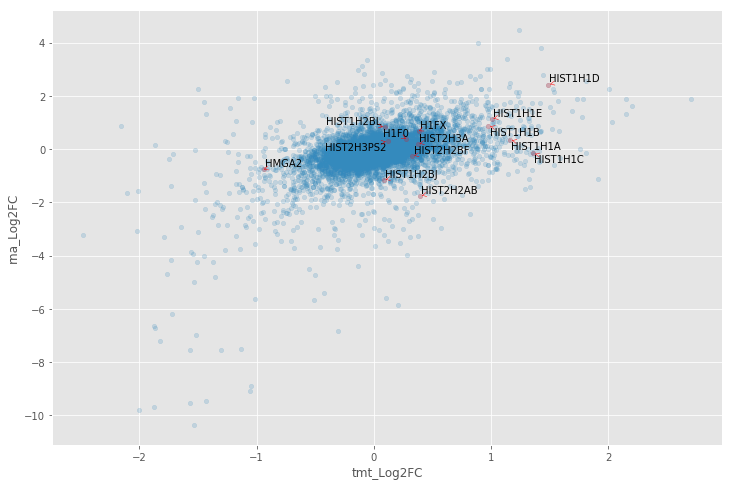

In [282]:
fig,ax=plt.subplots(figsize=(12,8))
x= 'tmt_Log2FC'
y = 'rna_Log2FC'
merge.plot(kind='scatter',x=x, y=y, alpha=0.2, ax=ax)
temp = merge.loc[histones_df['genes']]
temp = temp.dropna()
temp.plot(kind='scatter',x=x, y=y, c='r',alpha=0.2, ax=ax)

texts = [ ax.text(merge.loc[i][x], merge.loc[i][y], merge.loc[i]['Associated.Gene.Name'])
                       for i in temp.index.values ]
adjust_text(texts, arrowprops=dict(arrowstyle='->',
                                       color='red'),
                ax=ax)

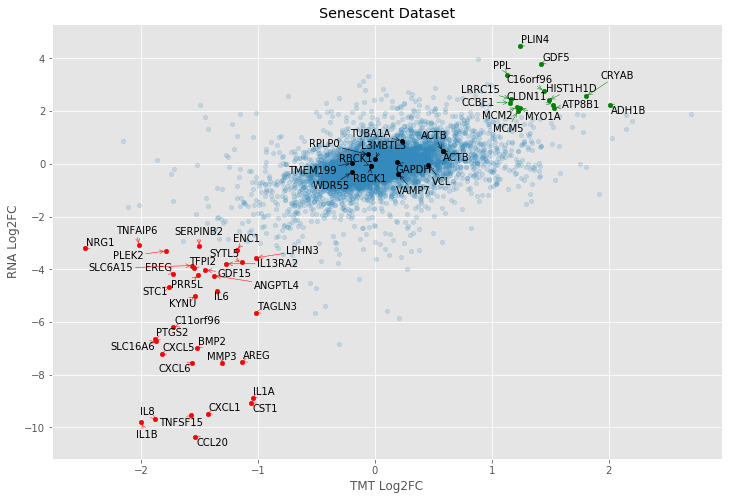

In [330]:
fig,ax=plt.subplots(figsize=(12,8))
x= 'tmt_Log2FC'
y = 'rna_Log2FC'
merge.plot(kind='scatter',x=x, y=y, alpha=0.2, ax=ax)

temp = merge[ (merge[x]<-1) & (merge[y]<-3)]
temp = temp.dropna()
temp.plot(kind='scatter',x=x, y=y, c='r', ax=ax)

texts = [ ax.text(merge.loc[i][x], merge.loc[i][y], 
                  merge.loc[i]['Associated.Gene.Name'])
                       for i in temp.index.values ]
adjust_text(texts, arrowprops=dict(arrowstyle='->',
                                       color='red'),
                ax=ax)

temp = merge[ (merge[x]>1) & (merge[y]>2)]
temp = temp.dropna()
temp.plot(kind='scatter',x=x, y=y, c='g', ax=ax)

texts = [ ax.text(merge.loc[i][x], merge.loc[i][y], 
                  merge.loc[i]['Associated.Gene.Name'])
                       for i in temp.index.values ]
adjust_text(texts, arrowprops=dict(arrowstyle='->',
                                       color='green'),
                ax=ax)

#PMID: 30710410
'''ENSG00000244045 TMEM199
ENSG00000124333 VAMP7
ENSG00000198945 L3MBTL3
ENSG00000120314 WDR55
ENSG00000089157 RPLP0
ENSG00000075624 ACTB
ENSG00000111640 GAPDH
ENSG00000125826 RBCK1
ENSG00000035403 VCL
ENSG00000167552 TUBA1A'''

control = ['ENSG00000244045','ENSG00000124333','ENSG00000198945','ENSG00000120314',
'ENSG00000089157','ENSG00000075624','ENSG00000075624','ENSG00000111640',
'ENSG00000125826','ENSG00000125826','ENSG00000035403','ENSG00000167552']


merge.loc[control].plot(kind='scatter',x=x, y=y, c='k', ax=ax)

texts = [ ax.text(merge.loc[i][x], merge.loc[i][y], 
                  merge.loc[i]['Associated.Gene.Name'])
                       for i in control]
adjust_text(texts, arrowprops=dict(arrowstyle='->',
                                       color='k'),
                ax=ax)



ax.set_xlabel('TMT Log2FC')
ax.set_ylabel('RNA Log2FC')

plt.title('Senescent Dataset')
plt.savefig('RNA_PROT_analysis.png')
plt.show()

In [320]:
from sklearn.linear_model import HuberRegressor,Ridge
huber = HuberRegressor(epsilon=50).fit(merge[[x]], merge[y])
print(huber.score(merge[[x]], merge[y]))
ridge = Ridge(alpha=20).fit(merge[[x]], merge[y])
print(ridge.score(merge[[x]], merge[y]))

0.21918684326145
0.21913271470673001


In [179]:
protein_complex = pd.read_table('homo_sapiens_interactions.tsv')
col = 'Identifiers (and stoichiometry) of molecules in complex'
protein_complex = protein_complex[~protein_complex[col].str.contains('(0)')]
protein_complex['components'] = [len(n.split('|')) for n in protein_complex[col]]
protein_complex=protein_complex[protein_complex['components']>1]
print(protein_complex.shape)

ids = []
ste = []
for pcomplex in protein_complex[col]:
    components = pcomplex.split('|')
    ids .append([n.split('(')[0] for n in components])
    ste.append([int(n.split('(')[1].replace(')','')) for n in components])

protein_complex['ids']=ids
protein_complex['ste']=ste

(80, 19)


In [188]:
res = []
for items in protein_complex['ids']:
    temp = []
    for prot in items:
        temp.append(df['Fasta headers'].str.contains(prot).sum())
    res.append(sum(temp))
protein_complex['in_dataset']=res

In [190]:
protein_complex = protein_complex[protein_complex['components']==protein_complex['in_dataset']]
cols = ['#Complex ac','Recommended name','components','in_dataset','ids','ste']
print(protein_complex.shape)
protein_complex[cols]

(38, 22)


,#Complex ac,Recommended name,components,in_dataset,ids,ste
158,CPX-1911,BLOC1S1-CNO-PLDN complex,3,3,"[P78537, Q9UL45, Q9NUP1]","[1, 1, 1]"
163,CPX-1912,BLOC1S2-SNAPN-DTBP1,3,3,"[O95295, Q96EV8, Q6QNY1]","[1, 1, 1]"
166,CPX-1941,"Exon junction core complex, MAGOH variant",4,4,"[P38919, O15234, Q9Y5S9, P61326]","[1, 1, 1, 1]"
169,CPX-1942,Exon junction subcomplex MAGOH-Y14,2,2,"[Q9Y5S9, P61326]","[1, 1]"
172,CPX-1969,Cyclin C-CDK8 complex,2,2,"[P24863, P49336]","[1, 1]"
213,CPX-3199,KIF3 complex variant AC,2,2,"[Q9Y496, O14782]","[1, 1]"
214,CPX-3200,KIF3 complex variant AC-KAP3,3,3,"[O14782, Q9Y496, Q92845]","[1, 1, 1]"
216,CPX-3208,SMAD2-SMAD4 complex,3,3,"[Q15796, Q13485, Q15796]","[1, 1, 1]"
228,CPX-2165,Protein farnesyltransferase complex,2,2,"[P49354, P49356]","[1, 1]"
270,CPX-2887,PDGF receptor alpha - PDGF-CC complex,2,2,"[Q9NRA1, P16234]","[2, 2]"
